# Artificial Neural Networks and Deep Learning - Homework 2


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount("/gdrive")
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2024-12-08 22:46:12.567133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 22:46:12.603905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 22:46:12.615588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 22:46:12.643646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 22:46:14.304262: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


I0000 00:00:1733694377.579230  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733694377.684873  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733694377.687251  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# Set the mixed precision policy to use float16 (half precision)
policy = tfk.mixed_precision.Policy('mixed_float16')
tfk.mixed_precision.set_global_policy(policy)

## ⏳ Load and prepare the Data

In [4]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [6]:
# Remove outliers (containing aliens)
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [7]:
# Count the number of pixels with a given label
label_list, counts = np.unique(y_train, return_counts=True)
for label, count in zip(label_list, counts):
    print(f"Number of pixels with label {int(label)}: {count}")

Number of pixels with label 0: 4988826
Number of pixels with label 1: 6957538
Number of pixels with label 2: 4776810
Number of pixels with label 3: 3770823
Number of pixels with label 4: 26963


In [8]:
# Count the number of images containing a pixel with a given label
counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        counts[int(value)] += 1
for label, count in enumerate(counts):
    print(f"Number of images containing label {int(label)}: {count}")

Number of images containing label 0: 2087
Number of images containing label 1: 1281
Number of images containing label 2: 1160
Number of images containing label 3: 863
Number of images containing label 4: 63


In [9]:
# Since there are few images with label 4, stratify using the presence of label 4
stratify=[]
for labels in y_train:
    label_list = np.unique(labels)
    if 4.0 in label_list:
        stratify.append(1)
    else:
        stratify.append(0)
stratify = np.array(stratify)

In [10]:
# Split into training and validation (80-20)
val_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=val_size
)

In [11]:
# Check imbalance between training and validation
train_counts = [0 for _ in range(num_classes)]
for labels in y_train:
    label_list = np.unique(labels)
    for value in label_list:
        train_counts[int(value)] += 1

val_counts = [0 for _ in range(num_classes)]
for labels in y_val:
    label_list = np.unique(labels)
    for value in label_list:
        val_counts[int(value)] += 1

ratios = [val_counts[i] / train_counts[i] / val_size for i in range(num_classes)]

for i in range(num_classes):
    print(f"Ratio of images containing a label in validation vs train compared to ideal split for label {i}: {ratios[i]}")

Ratio of images containing a label in validation vs train compared to ideal split for label 0: 1.2150089338892196
Ratio of images containing a label in validation vs train compared to ideal split for label 1: 1.3667992047713717
Ratio of images containing a label in validation vs train compared to ideal split for label 2: 1.1246040126715944
Ratio of images containing a label in validation vs train compared to ideal split for label 3: 1.2718023255813953
Ratio of images containing a label in validation vs train compared to ideal split for label 4: 0.625


In [12]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def random_flip_h(image, label):
    """Consistent random horizontal flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

@tf.function
def random_flip_v(image, label):
    """Consistent random vertical flip."""
    flip_prob = tf.random.uniform([])
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(label), lambda: label
    )
    return image, label

@tf.function
def random_brightness(image):
    delta = tf.random.uniform([])
    delta_thresh = 0.1
    image = tf.cond(
        delta < 3*delta_thresh, lambda: tf.image.adjust_brightness(image, delta=delta), lambda: image
    )
    return image

@tf.function
def random_contrast(image):
    factor = tf.random.uniform([])
    factor_thresh = 2
    image = tf.cond(
        factor < factor_thresh/6, lambda: tf.image.adjust_contrast(image, contrast_factor=factor), lambda: image
    )
    return image

@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label)
    #image, label = random_flip_v(image, label)
    #image = random_brightness(image)
    #image = random_contrast(image)
    return image, label

In [14]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [15]:
batch_size = 32

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...


I0000 00:00:1733694384.620577  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733694384.622660  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733694384.624495  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733694384.863098  596520 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


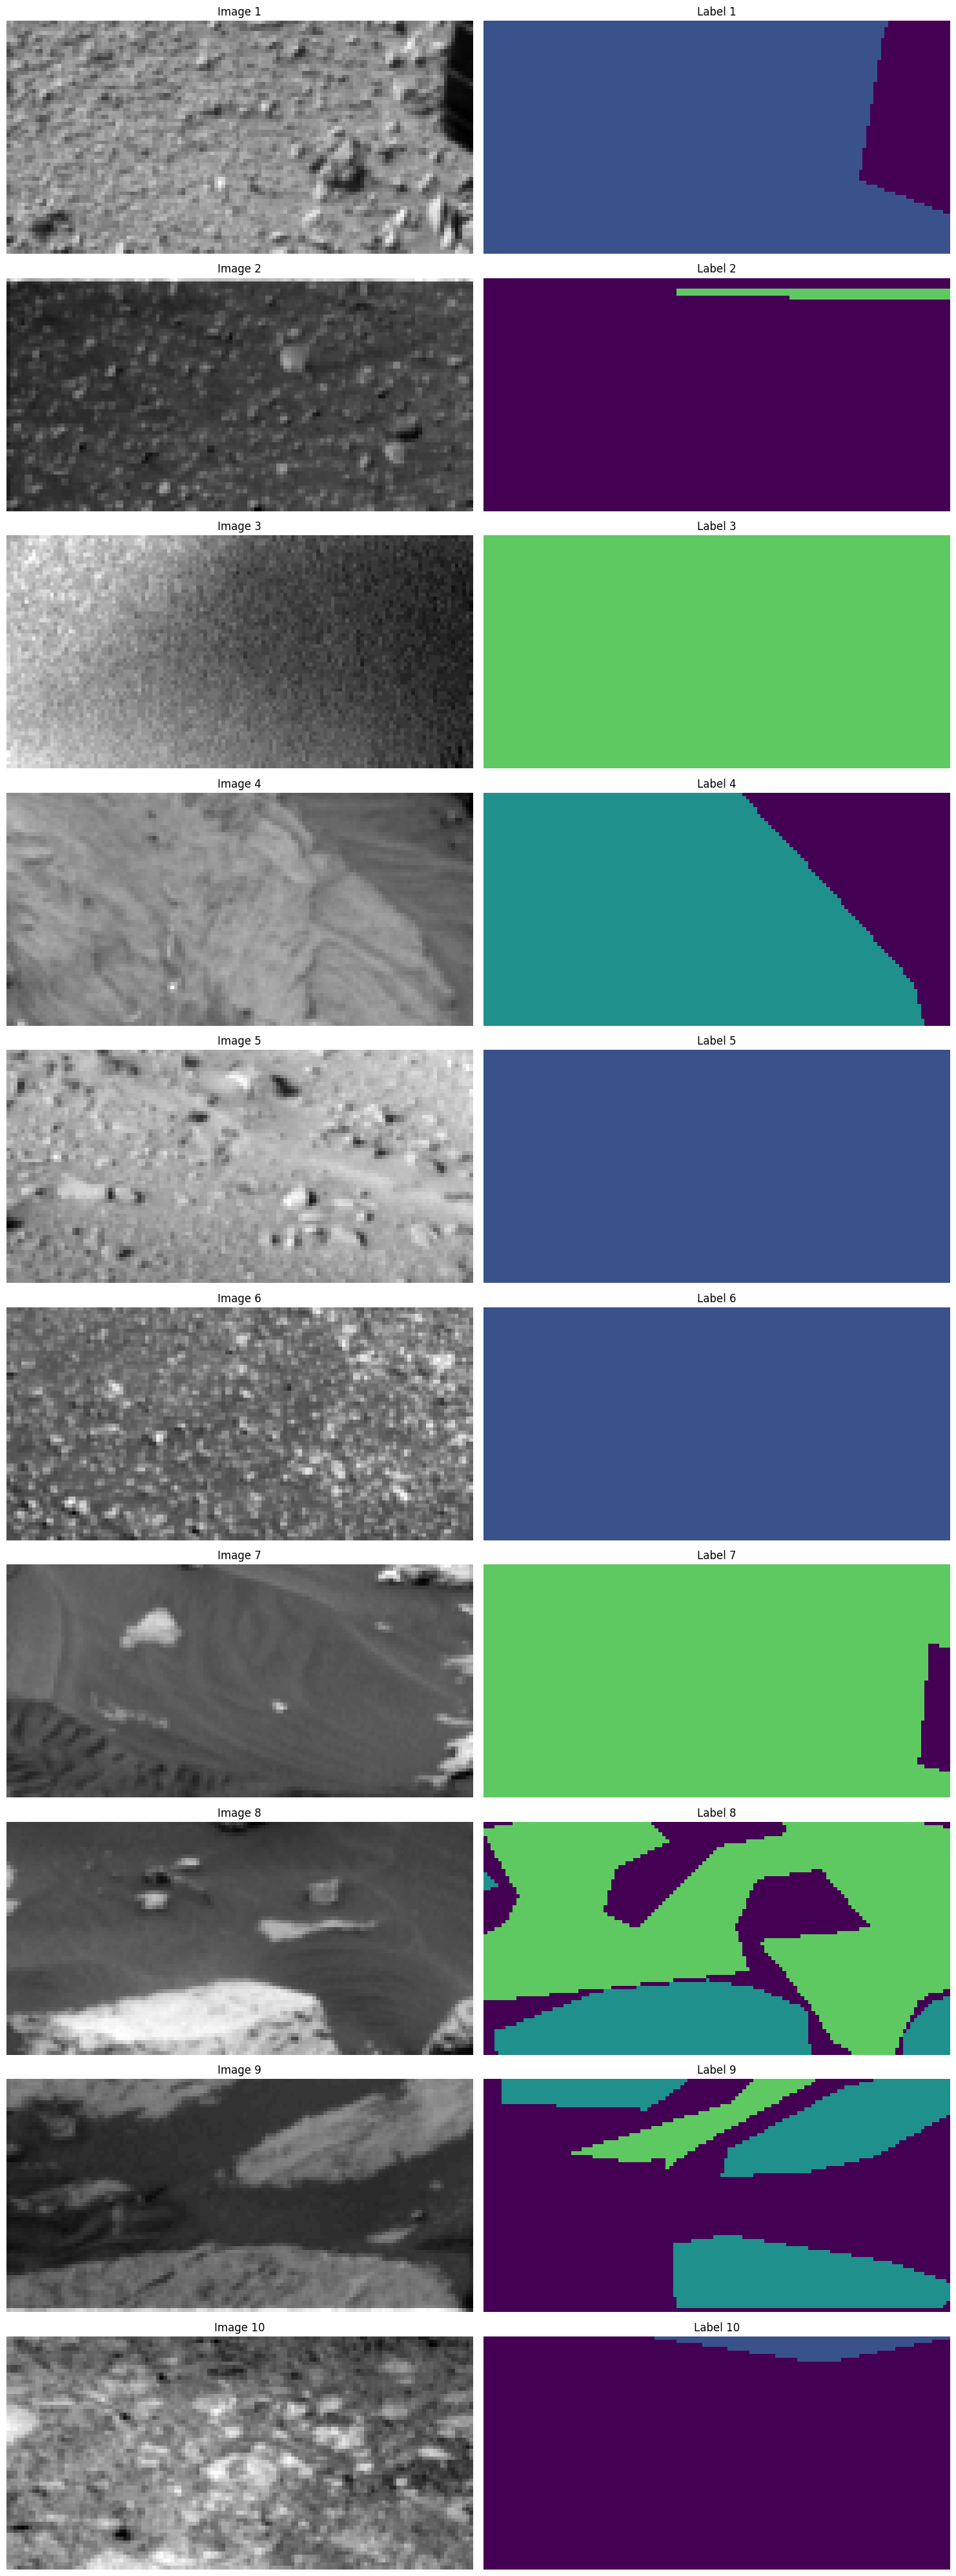

In [16]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="grey")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

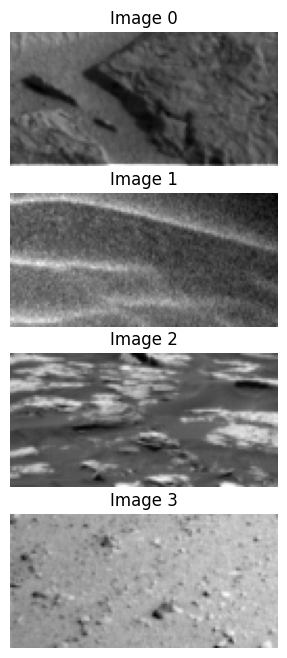

In [17]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="grey")
    plt.title(f"Image {j}")
    plt.axis("off")

## Train the model

In [18]:
from tensorflow.keras import backend as K

def iou_loss(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) loss.
    :param y_true: Ground truth tensor (not one-hot encoded).
    :param y_pred: Predicted tensor (probabilities or logits).
    :param smooth: Smoothing factor to avoid division by zero.
    :return: IoU loss value.
    """
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)

    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    # Loop over all classes (excluding class 0)
    for i in range(1, num_classes):  # Start from 1 to exclude background (class 0)
        # Get the probabilities for the current class (class i)
        y_pred_class = y_pred[..., i]
        y_true_class = y_true_one_hot[..., i]

        # Flatten the predicted probabilities and true labels for class i
        y_true_f_class = K.flatten(y_true_class)
        y_pred_f_class = K.flatten(y_pred_class)

        # Calculate intersection and union for class i
        intersection = K.sum(y_true_f_class * y_pred_f_class)
        union = K.sum(y_true_f_class) + K.sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = K.mean(K.stack(iou_values))

    # Return mean IoU loss (1 - mean IoU)
    return 1 - mean_iou

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [19]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

def print_confusion(model):
    # Predict class probabilities and get predicted classes on the validation set.
    test_predictions = np.argmax(model.predict(X_val), axis=-1).flatten()

    # Extract ground truth classes.
    test_gt = y_val.flatten()

    # Calculate and display test set accuracy.
    test_accuracy = accuracy_score(test_gt, test_predictions)
    print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

    # Calculate and display test set precision.
    test_precision = precision_score(test_gt, test_predictions, average='weighted')
    print(f'Precision score over the test set: {round(test_precision, 4)}')

    # Calculate and display test set recall.
    test_recall = recall_score(test_gt, test_predictions, average='weighted')
    print(f'Recall score over the test set: {round(test_recall, 4)}')

    # Calculate and display test set F1 score.
    test_f1 = f1_score(test_gt, test_predictions, average='weighted')
    print(f'F1 score over the test set: {round(test_f1, 4)}')

    # Compute the confusion matrix.
    cm = confusion_matrix(test_gt, test_predictions)

    # Create labels combining confusion matrix values.
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix with class labels.
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(num_classes), yticklabels=range(num_classes), cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

I0000 00:00:1733694408.060763  597291 service.cc:146] XLA service 0x7fe8b4002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733694408.060801  597291 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-08 22:46:48.358486: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 22:46:51.101848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4:28 18s/step

I0000 00:00:1733694418.432561  597291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step 
Accuracy score over the test set: 0.6304


/home/francezco/Desktop/exams/AN2DL/Lab/an2dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision score over the test set: 0.5837
Recall score over the test set: 0.6304
F1 score over the test set: 0.6055


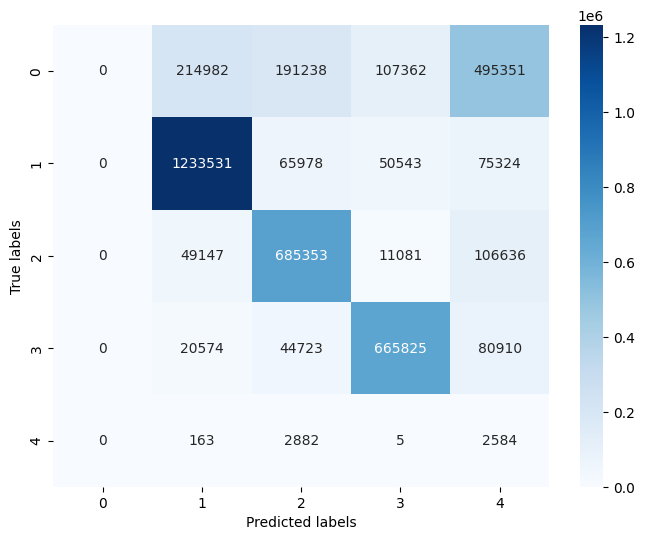

In [21]:
model_42 = tfk.models.load_model("best_model_42.keras", compile=False)
print_confusion(model_42)

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 849ms/step
Accuracy score over the test set: 0.6661


/home/francezco/Desktop/exams/AN2DL/Lab/an2dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision score over the test set: 0.6261
Recall score over the test set: 0.6661
F1 score over the test set: 0.6447


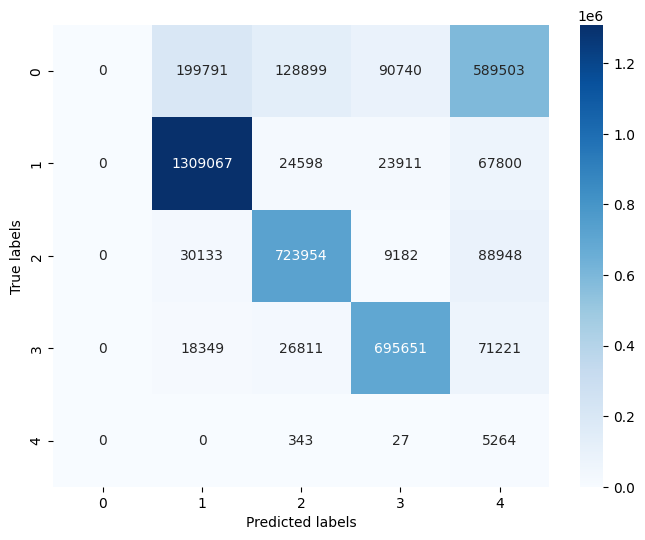

In [22]:
model_3 = tfk.models.load_model("best_model_3.keras", compile=False)
print_confusion(model_3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
Accuracy score over the test set: 0.4494


/home/francezco/Desktop/exams/AN2DL/Lab/an2dl_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision score over the test set: 0.3419
Recall score over the test set: 0.4494
F1 score over the test set: 0.3359


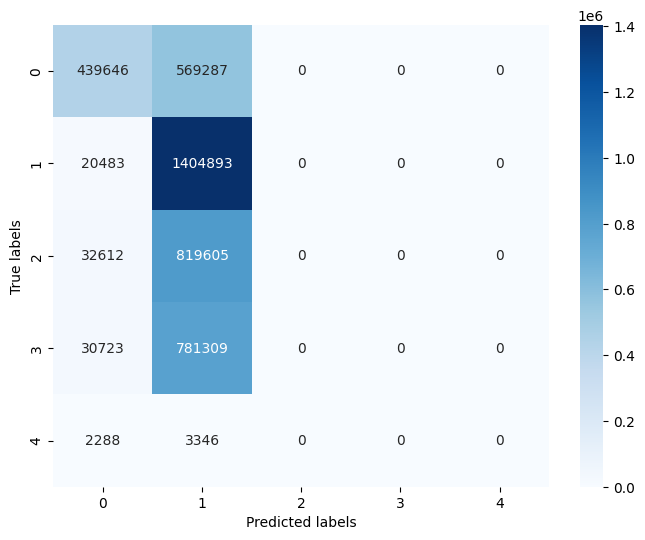

In [23]:
background_model = tfk.models.load_model("background.keras", compile=False)
print_confusion(background_model)

In [ ]:
def iou(y_true, y_pred):
    smooth = 1e-6
    
    # Initialize a list to store IoU values for each class (ignoring class 0)
    iou_values = []

    # Loop over all classes (excluding class 0)
    for i in range(1, num_classes):  # Start from 1 to exclude background (class 0)
        y_true_f_class = np.where(y_true == i, 1, 0).flatten()
        y_pred_f_class = np.where(y_pred == i, 1, 0).flatten()

        # Calculate intersection and union for class i
        intersection = sum(y_true_f_class * y_pred_f_class)
        union = sum(y_true_f_class) + sum(y_pred_f_class) - intersection

        # Compute IoU for this class
        iou_class = (intersection + smooth) / (union + smooth)
        iou_values.append(iou_class)

    # Compute the mean IoU over all classes (excluding class 0)
    mean_iou = sum(iou_values) / (num_classes - 1)
    return mean_iou

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Validation mean IoU: 0.5571810980415093
Accuracy score over the test set: 0.7638
Precision score over the test set: 0.8384
Recall score over the test set: 0.7638
F1 score over the test set: 0.7847


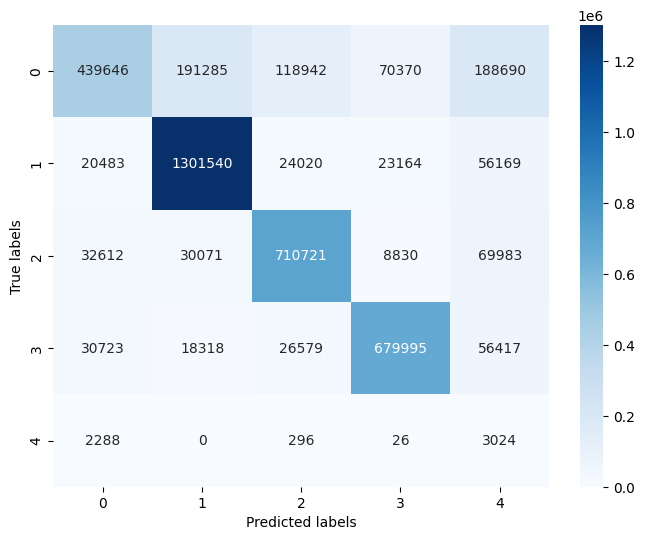

In [33]:
# Predict class probabilities and get predicted classes on the validation set.
val_predictions_42 = np.argmax(model_42.predict(X_val), axis=-1)
val_predictions_3 = np.argmax(model_3.predict(X_val), axis=-1)
val_predictions_back = np.argmax(background_model.predict(X_val), axis=-1)

val_predictions = np.where(val_predictions_back == 1, val_predictions_3, 0)

print("Validation mean IoU: " + str(iou(y_val, val_predictions)))

val_predictions = val_predictions.flatten()

# Extract ground truth classes.
test_gt = y_val.flatten()

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, val_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision.
test_precision = precision_score(test_gt, val_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall.
test_recall = recall_score(test_gt, val_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, val_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, val_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(num_classes), yticklabels=range(num_classes), cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [32]:
# Use the two models combined
test_predictions_3 = np.argmax(model_3.predict(X_test), axis=-1)
test_predictions_back = np.argmax(background_model.predict(X_test), axis=-1)

test_predictions = np.where(test_predictions_back == 1, test_predictions_3, 0)

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(test_predictions)
submission_df.to_csv(submission_filename, index=False)

314/314 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step


2024-12-08 22:56:05.981641: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642004480 exceeds 10% of free system memory.


314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```